In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/OhioDataset/train.csv'
file_path = '/content/drive/MyDrive/OhioDataset/test.csv'

Mounted at /content/drive


In [ ]:
# Example for reading a CSV file using pandas
import pandas as pd
df = pd.read_csv(file_path)

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# models
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
!pip install catboost
from catboost import CatBoostRegressor

!pip install --quiet optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
def visualize_null_values(df):

    # Calculate the percentage of null values per feature
    null_percentage = df.isnull().mean() * 100

    # Create categories based on null percentage ranges
    bins = [0, 25, 50, 75, 100]
    labels = ['0-25%', '25-50%', '50-75%', '75-100%']
    category_counts = pd.cut(null_percentage, bins=bins, labels=labels).value_counts().sort_index()

    # Create a figure with two subplots, one for the bar chart and one for the pie chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Bar graph showing number of features in each null percentage category
    bar = ax1.bar(category_counts.index, category_counts.values, color='skyblue')

    # Add numbers on top of each bar
    for i, value in enumerate(category_counts.values):
        ax1.text(i, value + 0.1, str(value), ha='center', fontsize=12)

    ax1.set_title('Features by Percentage of Null Values', fontsize=14)
    ax1.set_xlabel('Percentage of Null Values', fontsize=12)
    ax1.set_ylabel('Number of Features', fontsize=12)

    # Plot 2: Pie chart showing features with null values and without null values
    features_with_nulls = (null_percentage > 0).sum()
    features_without_nulls = (null_percentage == 0).sum()
    labels = ['Features with Null Values', 'Features without Null Values']
    sizes = [features_with_nulls, features_without_nulls]
    colors = ['#ff9999','#66b3ff']

    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Features with and without Null Values', fontsize=14)

    plt.tight_layout()
    plt.show()

In [ ]:
def most_common_activity_per_hour(df):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Most Common Activity at Each Hour', fontsize=16)
    colors = ['blue', 'cyan', 'pink', 'purple', 'red', 'orange']

    for i in range(6):
        row, col_idx = divmod(i, 3)

        top_10_activities = df[f'activity-{i}:00'].value_counts().nlargest(10).index
        filtered_df = df[df[f'activity-{i}:00'].isin(top_10_activities)]

        sns.countplot(filtered_df, x=f'activity-{i}:00', ax=axes[row, col_idx], color=colors[i])
        axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotation=45)
        axes[row, col_idx].set_title(f'Activity at time {i}:00')
        axes[row, col_idx].set_xlabel('Activity')
        axes[row, col_idx].set_ylabel('Count')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
def boxplot_bg_per_hour(h):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=f"activity-{h}:00", y=f"bg-{h}:00", data=train_df)
    plt.xticks(rotation=45)
    plt.title(f"Impact of Activities on Blood Glucose Levels at hour {h}:00")
    plt.xlabel('Activity')
    plt.ylabel('Blood Glucose (mmol/L)')
    plt.show()

### Train Model and Predict

def train_and_predict(model, X_train, y_train, X_test, y_test):
    # train the model
    model.fit(X_train, y_train)

    # predict and evaluate
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    return train_pred, test_pred, train_rmse, test_rmse

In [ ]:
# Separate variables for clarity
train_file_path = '/content/drive/MyDrive/OhioDataset/train.csv'
test_file_path = '/content/drive/MyDrive/OhioDataset/test.csv'

# Read files (using the fix from above)
train_df = pd.read_csv(train_file_path, low_memory=False)
test_df = pd.read_csv(test_file_path, low_memory=False)

In [ ]:
train_df

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177019,p12_25294,p12,23:35:00,8.8,9.1,9.2,9.4,9.8,10.2,10.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.1
177020,p12_25295,p12,23:40:00,9.1,9.2,9.4,9.8,10.2,10.4,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9
177021,p12_25296,p12,23:45:00,9.2,9.4,9.8,10.2,10.4,10.3,10.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.7
177022,p12_25297,p12,23:50:00,9.4,9.8,10.2,10.4,10.3,10.1,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.5


In [ ]:
test_df

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
0,p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk
2,p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,p24_256,p24,06:40:00,7.3,7.3,7.1,6.7,6.8,6.8,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3640,p24_257,p24,12:30:00,6.0,6.2,6.2,6.2,5.8,5.5,5.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3641,p24_258,p24,03:45:00,12.4,12.5,12.7,13.1,13.2,13.3,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3642,p24_259,p24,06:10:00,8.3,8.3,8.2,8.2,7.8,7.4,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_df.describe().transpose()

In [ ]:
train_df.info(show_counts=True, verbose=True)

In [ ]:
train_df['p_num']

,p_num
0,p01
1,p01
2,p01
3,p01
4,p01
...,...
177019,p12
177020,p12
177021,p12
177022,p12


In [ ]:
test_df['p_num']

,p_num
0,p01
1,p01
2,p01
3,p01
4,p01
...,...
3639,p24
3640,p24
3641,p24
3642,p24


In [ ]:
# Change p_num to be integer numbers
train_df['p_num'] = train_df['p_num'].str.extract(r'(\d+)').astype(int)
test_df['p_num'] = test_df['p_num'].str.extract(r'(\d+)').astype(int)

In [ ]:
train_df['p_num']

,p_num
0,1
1,1
2,1
3,1
4,1
...,...
177019,12
177020,12
177021,12
177022,12


In [ ]:
test_df['p_num']

,p_num
0,1
1,1
2,1
3,1
4,1
...,...
3639,24
3640,24
3641,24
3642,24


In [ ]:
activity_cols = [col for col in train_df.columns if col.startswith('activity')]

In [ ]:
for col in activity_cols:
    train_df[col] = train_df[col].apply(lambda x: 'Walking' if x == 'Walk' else x)
    test_df[col] = test_df[col].apply(lambda x: 'Walking' if x == 'Walk' else x)

In [ ]:
activities = ['No Activity', 'Indoor climbing','Run','Strength training','Swim','Bike','Dancing','Stairclimber','Spinning','Walking','HIIT','Outdoor Bike','Aerobic Workout','Tennis','Workout','Hike','Zumba','Sport','Yoga','Swimming','Weights','Running']
activites_encode = {activity: i for i, activity in enumerate(activities)}
activites_encode

{'No Activity': 0,
 'Indoor climbing': 1,
 'Run': 2,
 'Strength training': 3,
 'Swim': 4,
 'Bike': 5,
 'Dancing': 6,
 'Stairclimber': 7,
 'Spinning': 8,
 'Walking': 9,
 'HIIT': 10,
 'Outdoor Bike': 11,
 'Aerobic Workout': 12,
 'Tennis': 13,
 'Workout': 14,
 'Hike': 15,
 'Zumba': 16,
 'Sport': 17,
 'Yoga': 18,
 'Swimming': 19,
 'Weights': 20,
 'Running': 21}

In [ ]:
train_df[activity_cols].mode().iloc[0]

,0
activity-5:55,Walking
activity-5:50,Walking
activity-5:45,Walking
activity-5:40,Walking
activity-5:35,Walking
...,...
activity-0:20,Walking
activity-0:15,Walking
activity-0:10,Walking
activity-0:05,Walking


In [ ]:
test_df[activity_cols].mode().iloc[0]

,0
activity-5:55,Walking
activity-5:50,Walking
activity-5:45,Walking
activity-5:40,Walking
activity-5:35,Walking
...,...
activity-0:20,Walking
activity-0:15,Walking
activity-0:10,Walking
activity-0:05,Walking


/tmp/ipython-input-371412992.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotation=45)
/tmp/ipython-input-371412992.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotation=45)
/tmp/ipython-input-371412992.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotation=45)
/tmp/ipython-input-371412992.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotat

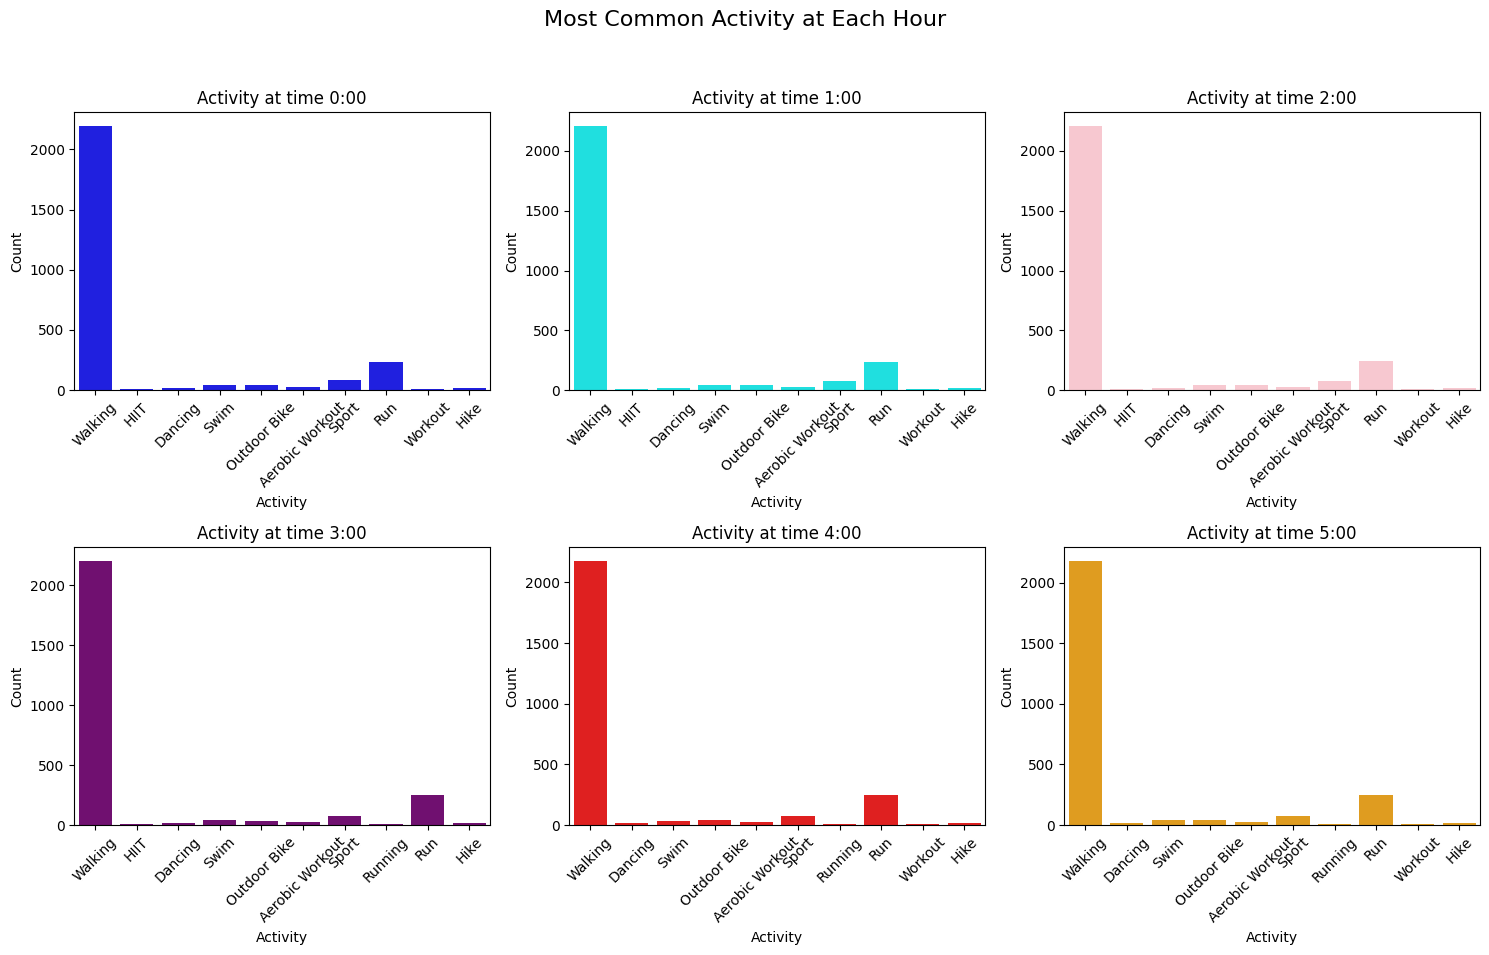

In [ ]:
most_common_activity_per_hour(train_df)

/tmp/ipython-input-371412992.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotation=45)
/tmp/ipython-input-371412992.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotation=45)
/tmp/ipython-input-371412992.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotation=45)
/tmp/ipython-input-371412992.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotat

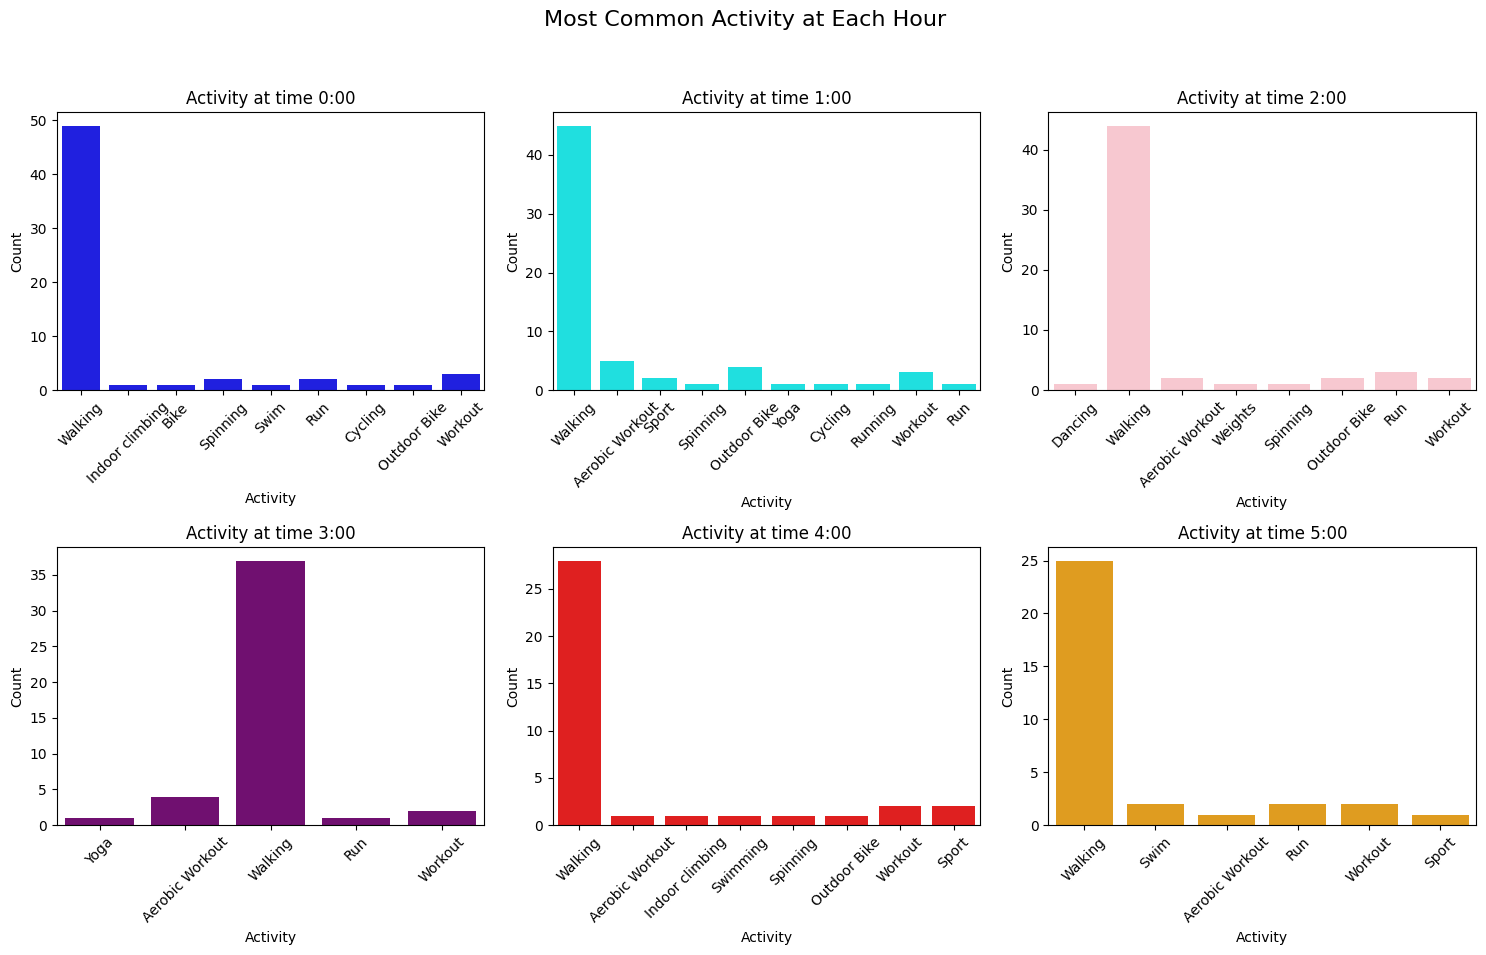

In [ ]:
most_common_activity_per_hour(test_df)

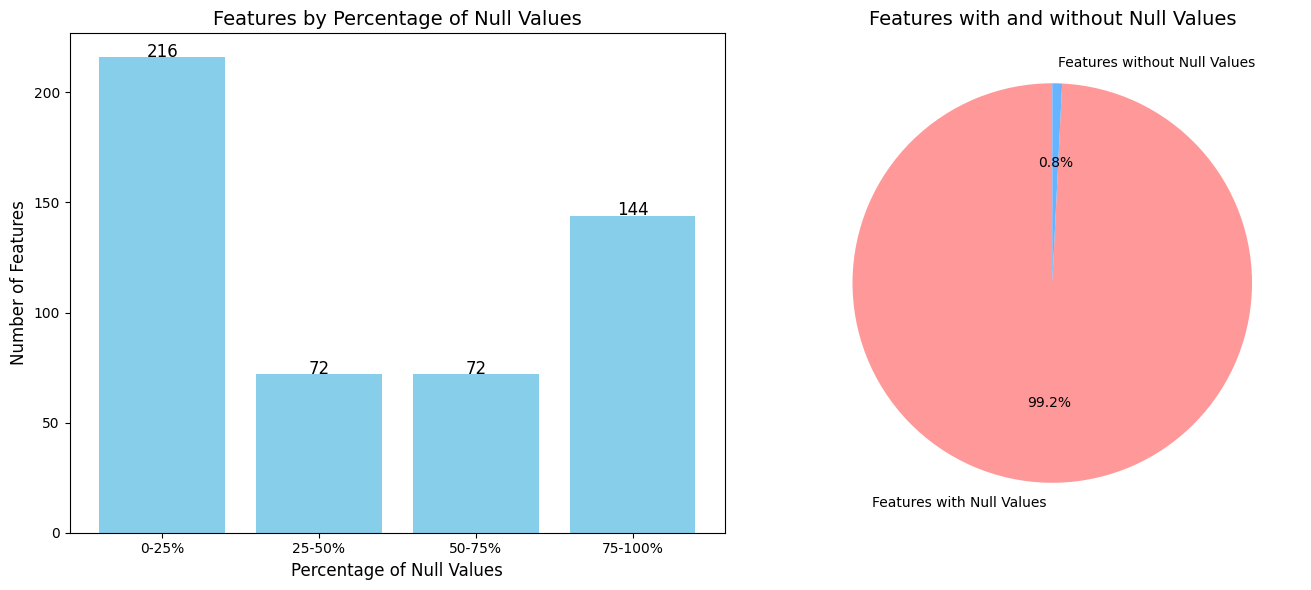

In [ ]:
visualize_null_values(train_df)

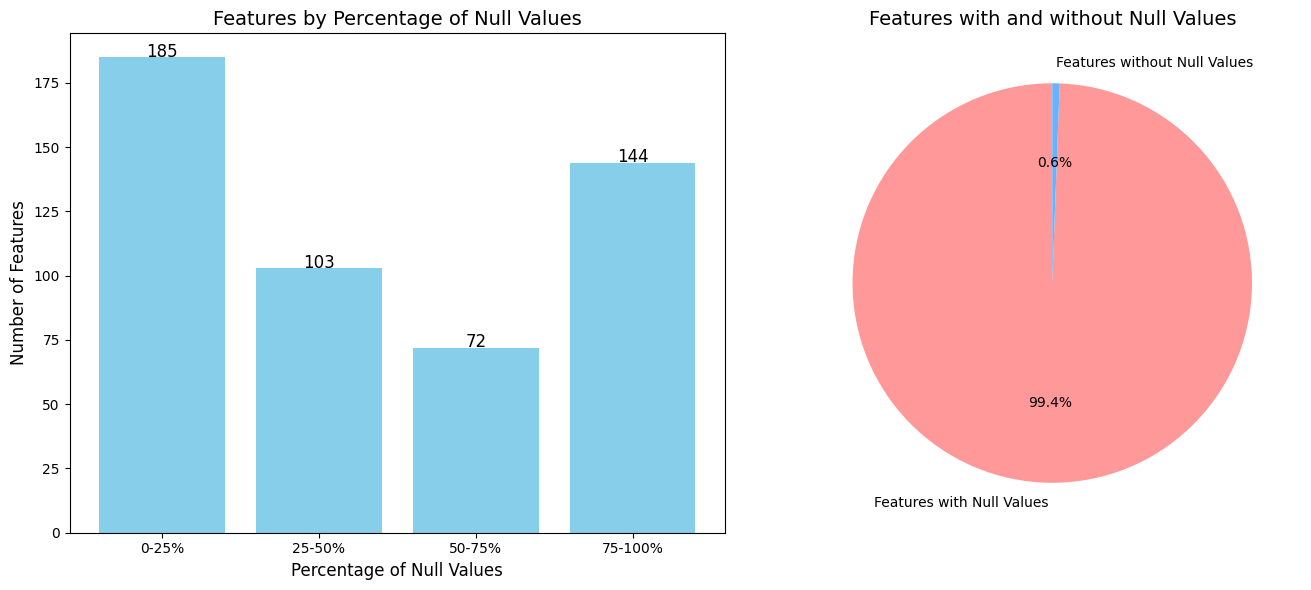

In [ ]:
visualize_null_values(test_df)

In [ ]:
# Apply mapping
for col in activity_cols:
    train_df[col] = train_df[col].apply(lambda x: activites_encode[x] if x in activites_encode else activites_encode['No Activity'])
    test_df[col] = test_df[col].apply(lambda x: activites_encode[x] if x in activites_encode else activites_encode['No Activity'])

In [ ]:
train_df["activity-5:55"].unique()

array([ 0,  9,  1, 18, 16, 10,  6,  4, 11, 12, 17, 21, 19,  2, 20, 14, 13,
        3,  7,  8, 15,  5])

In [ ]:
numeric_columns_train = train_df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns_test = test_df.select_dtypes(include=['float64', 'int64']).columns

train_df[numeric_columns_train] = train_df[numeric_columns_train].ffill(axis=1)
train_df[numeric_columns_train] = train_df[numeric_columns_train].bfill(axis=1)
test_df[numeric_columns_test] = test_df[numeric_columns_test].ffill(axis=1)
test_df[numeric_columns_test] = test_df[numeric_columns_test].bfill(axis=1)

In [ ]:
print("\nMissing values after forward and backward fill:")
print(train_df[numeric_columns_train].isnull().sum())
print(test_df[numeric_columns_test].isnull().sum())


Missing values after forward and backward fill:
p_num            0
bg-5:55          0
bg-5:50          0
bg-5:45          0
bg-5:40          0
                ..
activity-0:15    0
activity-0:10    0
activity-0:05    0
activity-0:00    0
bg+1:00          0
Length: 506, dtype: int64
p_num            0
bg-5:55          0
bg-5:50          0
bg-5:45          0
bg-5:40          0
                ..
activity-0:20    0
activity-0:15    0
activity-0:10    0
activity-0:05    0
activity-0:00    0
Length: 505, dtype: int64


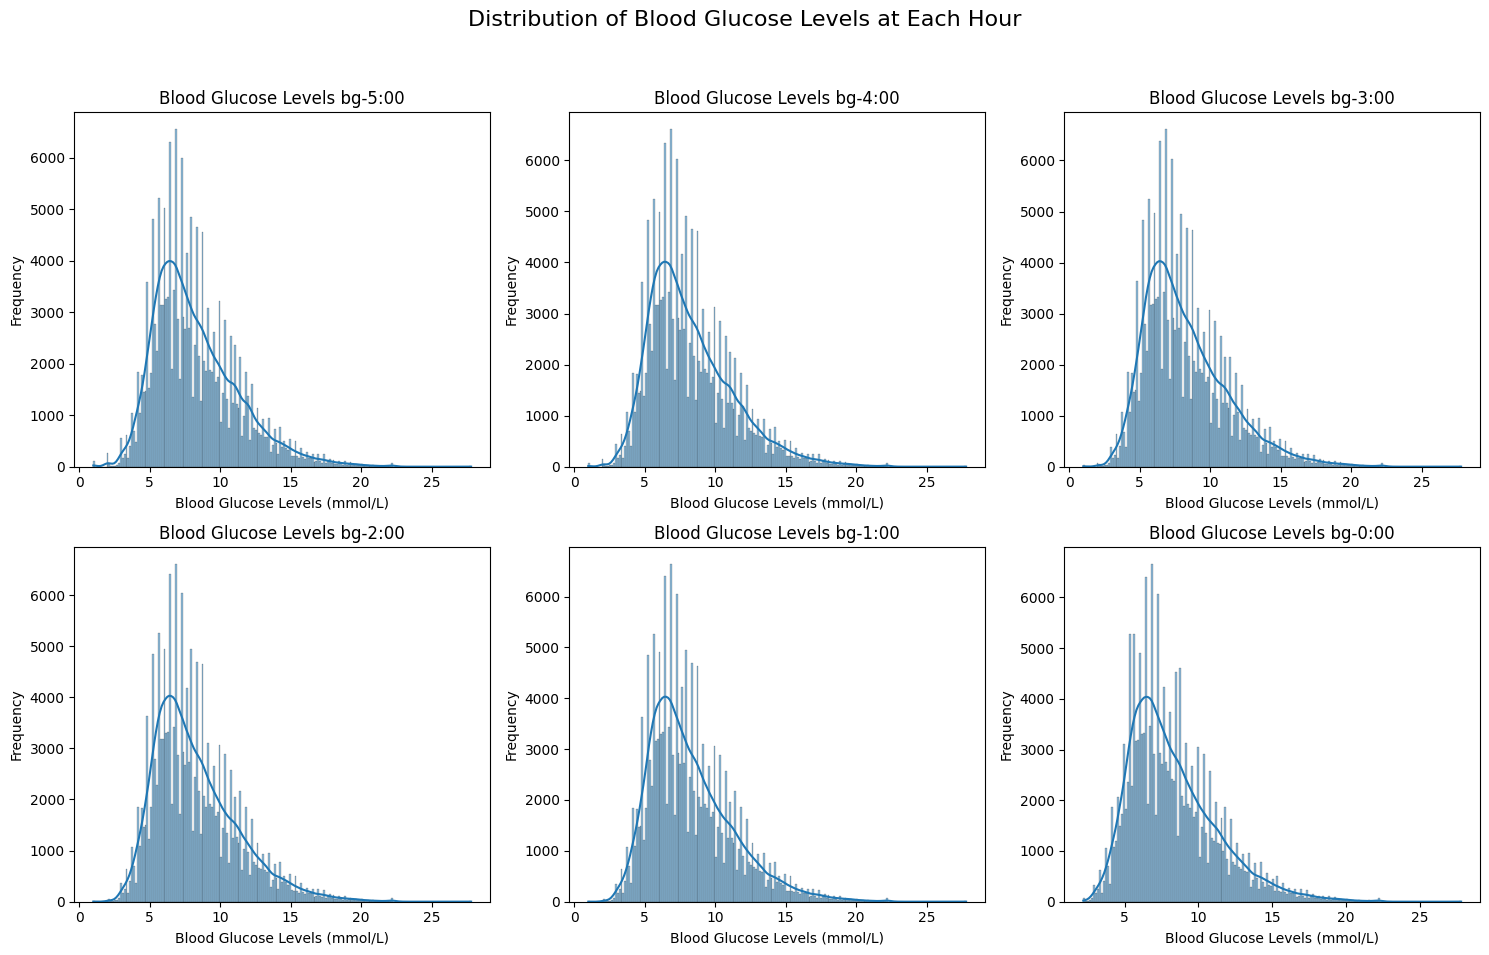

In [ ]:
bg_columns = [f'bg-{hour}:00' for hour in range(5, -1, -1)]  # Creates bg-5:00, bg-4:00, ..., bg-0:00

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Distribution of Blood Glucose Levels at Each Hour', fontsize=16)

# Iterate over each column and plot the histogram in the corresponding subplot
for i, col in enumerate(bg_columns):
    row, col_idx = divmod(i, 3)
    sns.histplot(train_df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Blood Glucose Levels {col}')
    axes[row, col_idx].set_xlabel('Blood Glucose Levels (mmol/L)')
    axes[row, col_idx].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

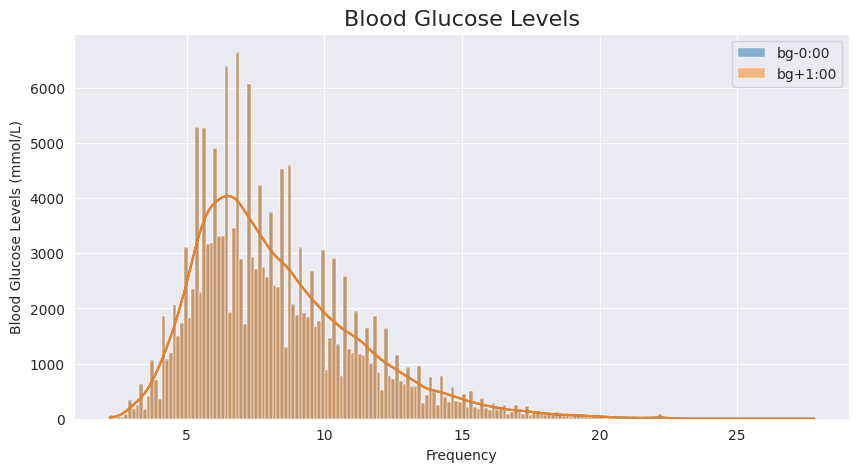

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.histplot(data=train_df, x="bg-0:00", kde=True, ax=ax, label="bg-0:00")
sns.histplot(data=train_df, x="bg+1:00", kde=True, ax=ax, label="bg+1:00")
ax.set_title("Blood Glucose Levels", fontsize=16)
ax.set_ylabel('Blood Glucose Levels (mmol/L)')
ax.set_xlabel("Frequency")
ax.legend(loc="upper right")

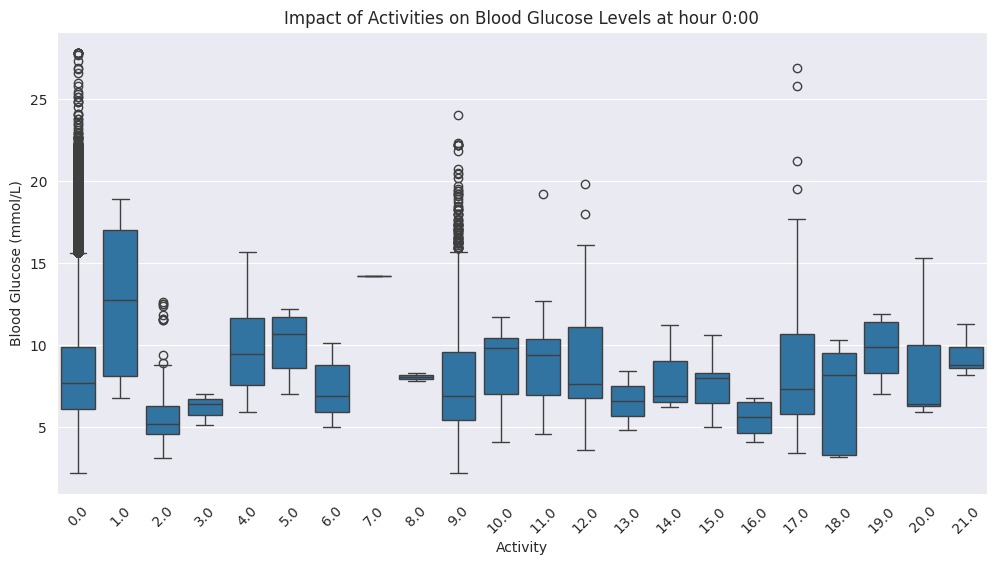

In [ ]:
boxplot_bg_per_hour(0)

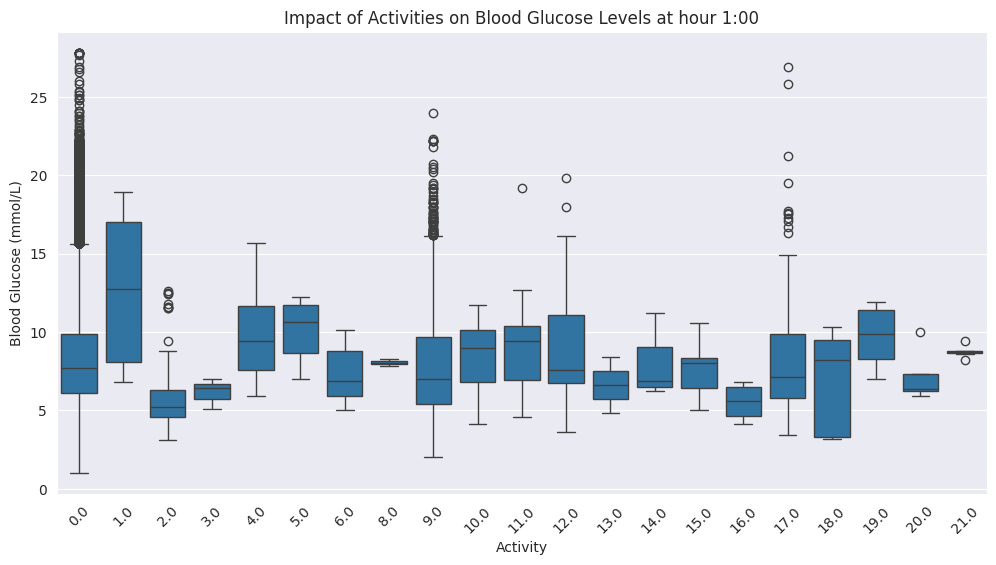

In [ ]:
boxplot_bg_per_hour(1)

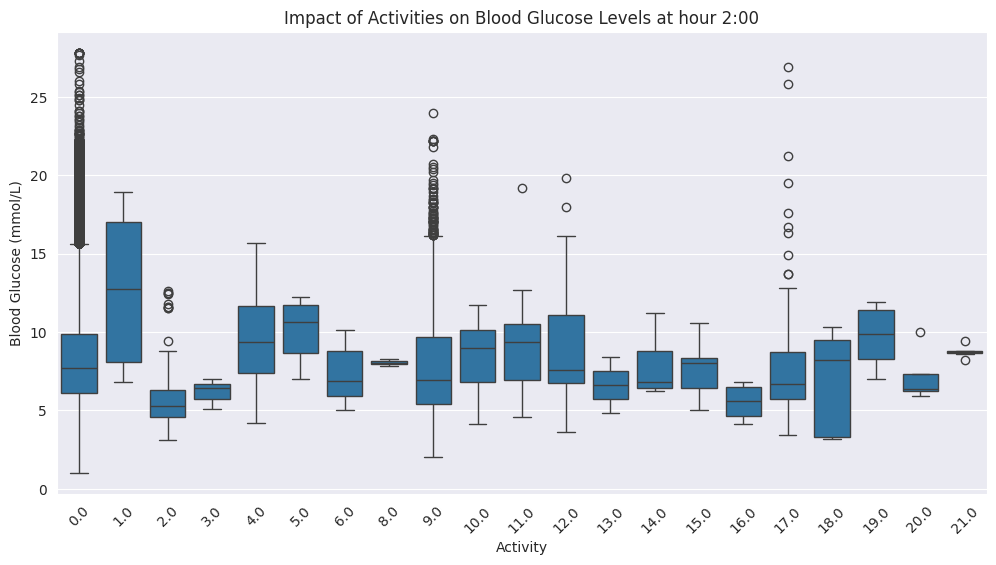

In [ ]:
boxplot_bg_per_hour(2)

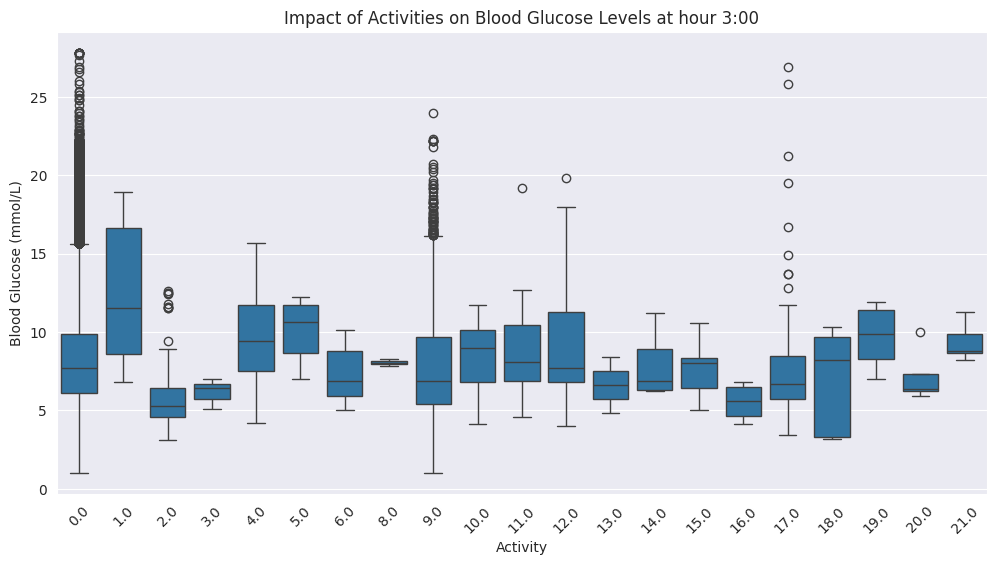

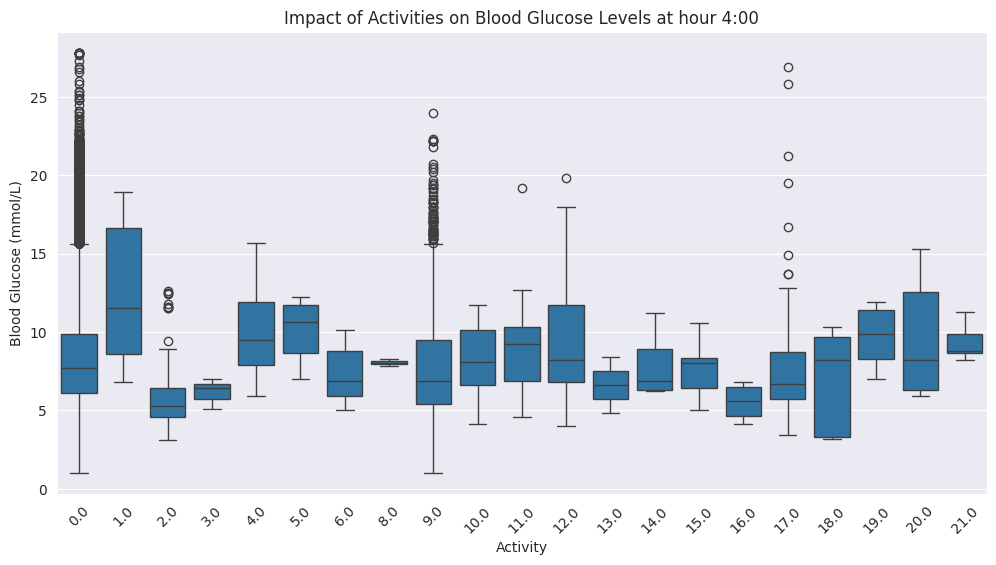

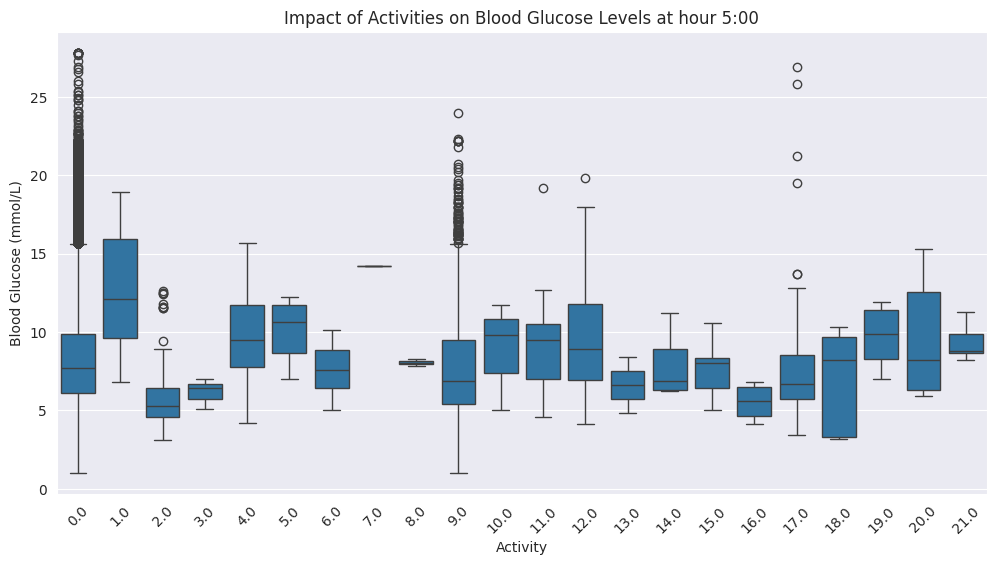

In [ ]:
boxplot_bg_per_hour(3)
boxplot_bg_per_hour(4)
boxplot_bg_per_hour(5)

In [ ]:
import pandas as pd
# Assuming train_df and test_df are already defined here...

try:
    # 1. Read the sample submission file
    sample_submission_df = pd.read_csv(
        '/content/drive/MyDrive/OhioDataset/sample_submission.csv',
        low_memory=False
    )

    # 2. Re-run the column manipulation line
    sample_submission_df.columns = (
        sample_submission_df.columns
        .str.replace(r'[^A-Za-z0-9_]+', '_')
        .str.strip('_')
        .str.lower()
        .str.replace('__', '_')
    )

except FileNotFoundError:
    print("Error: 'sample_submission.csv' file not found. Skipping submission processing.")
    # If the file is missing, you may need to define an empty dataframe
    # or skip the rest of the code that uses this variable.

In [ ]:
# changing special characters because some models can't handle them (such as LightGBM)
train_df.columns = train_df.columns.str.replace(":", "-")
test_df.columns = test_df.columns.str.replace(":", "-")

train_df.columns = train_df.columns.str.replace("_", "-")
test_df.columns = test_df.columns.str.replace("_", "-")

sample_submission_df.columns = sample_submission_df.columns.str.replace(":", "-")
sample_submission_df.columns = sample_submission_df.columns.str.replace("_", "-")

In [ ]:
bg_columns = [f'bg-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
hr_columns = [f'hr-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
insulin_columns = [f'insulin-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
carbs_columns = [f'carbs-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
steps_columns = [f'steps-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
cals_columns = [f'cals-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
activity_columns = [f'activity-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]

train_df = train_df[["id", "p-num", "time"] + bg_columns + insulin_columns + carbs_columns + hr_columns + steps_columns + cals_columns + activity_columns + ["bg+1-00"]]
test_df = test_df[["id", "p-num", "time"] + bg_columns + insulin_columns + carbs_columns + hr_columns + steps_columns + cals_columns + activity_columns]

In [ ]:
# extract hour, minute and second
train_df['hour'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.hour
train_df['minute'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.minute
train_df['second'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.second

test_df['hour'] = pd.to_datetime(test_df['time'], format='%H:%M:%S').dt.hour
test_df['minute'] = pd.to_datetime(test_df['time'], format='%H:%M:%S').dt.minute
test_df['second'] = pd.to_datetime(test_df['time'], format='%H:%M:%S').dt.second

# add cyclic features
train_df['hour-sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
train_df['hour-cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)
train_df['minute-sin'] = np.sin(2 * np.pi * train_df['minute'] / 60)
train_df['minute-cos'] = np.cos(2 * np.pi * train_df['minute'] / 60)
train_df['second-sin'] = np.sin(2 * np.pi * train_df['second'] / 60)
train_df['second-cos'] = np.cos(2 * np.pi * train_df['second'] / 60)

test_df['hour-sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df['hour-cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['minute-sin'] = np.sin(2 * np.pi * test_df['minute'] / 60)
test_df['minute-cos'] = np.cos(2 * np.pi * test_df['minute'] / 60)
test_df['second-sin'] = np.sin(2 * np.pi * test_df['second'] / 60)
test_df['second-cos'] = np.cos(2 * np.pi * test_df['second'] / 60)

/tmp/ipython-input-2969196315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.hour
/tmp/ipython-input-2969196315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['minute'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.minute
/tmp/ipython-input-2969196315.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [ ]:
# delete hour column
train_df.drop(columns=['hour', 'minute', 'second', 'time'], inplace=True)
test_df.drop(columns=['hour', 'minute', 'second', 'time'], inplace=True)

/tmp/ipython-input-835769752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['hour', 'minute', 'second', 'time'], inplace=True)
/tmp/ipython-input-835769752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['hour', 'minute', 'second', 'time'], inplace=True)


In [ ]:
time_columns = ["hour-sin", "hour-cos", "minute-sin", "minute-cos", "second-sin", "second-cos"]
feature_columns = bg_columns + insulin_columns + carbs_columns + hr_columns + steps_columns + cals_columns + activity_columns + time_columns
participant_column = ['p-num']
target_column = ['bg+1-00']

In [ ]:
X_train, X_test, y_train, y_test = train_df[feature_columns], test_df[feature_columns], train_df[target_column], sample_submission_df[target_column]

In [ ]:
catboost_model = CatBoostRegressor()

In [ ]:
train_pred, test_pred, train_rmse, test_rmse = train_and_predict(catboost_model, X_train, y_train, X_test, y_test)

Learning rate set to 0.092762
0:	learn: 2.8672639	total: 303ms	remaining: 5m 2s
1:	learn: 2.7565201	total: 461ms	remaining: 3m 49s
2:	learn: 2.6615511	total: 631ms	remaining: 3m 29s
3:	learn: 2.5796042	total: 769ms	remaining: 3m 11s
4:	learn: 2.5097484	total: 937ms	remaining: 3m 6s
5:	learn: 2.4482004	total: 1.04s	remaining: 2m 52s
6:	learn: 2.3960673	total: 1.12s	remaining: 2m 38s
7:	learn: 2.3519983	total: 1.21s	remaining: 2m 29s
8:	learn: 2.3146385	total: 1.3s	remaining: 2m 23s
9:	learn: 2.2813551	total: 1.41s	remaining: 2m 19s
10:	learn: 2.2534312	total: 1.5s	remaining: 2m 14s
11:	learn: 2.2285648	total: 1.59s	remaining: 2m 10s
12:	learn: 2.2089295	total: 1.68s	remaining: 2m 7s
13:	learn: 2.1908054	total: 1.75s	remaining: 2m 3s
14:	learn: 2.1746753	total: 1.84s	remaining: 2m 1s
15:	learn: 2.1613891	total: 1.93s	remaining: 1m 58s
16:	learn: 2.1494797	total: 2.01s	remaining: 1m 56s
17:	learn: 2.1393332	total: 2.08s	remaining: 1m 53s
18:	learn: 2.1303001	total: 2.17s	remaining: 1m 52s

In [ ]:
print(f"Train RMSE (CatBoost): {train_rmse:.4f}")
print(f"Test RMSE (CatBoost): {test_rmse:.4f}")

Train RMSE (CatBoost): 1.6030
Test RMSE (CatBoost): 1.5608


In [ ]:
def objective(trial):
    # Suggest hyperparameters for CatBoost
    params = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # Create and train CatBoost model
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

    # Predict on validation set and calculate RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Create an Optuna study
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Run optimization for 50 trials

# Best hyperparameters and score
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-12-09 17:30:14,044] A new study created in memory with name: no-name-141a0a1c-406e-4ff3-9fd0-fde32121139a
[I 2025-12-09 17:30:23,519] Trial 0 finished with value: 1.4464956127663386 and parameters: {'colsample_bylevel': 0.08695219074669032, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.18978005369633452}. Best is trial 0 with value: 1.4464956127663386.
[I 2025-12-09 17:31:18,129] Trial 1 finished with value: 1.484921727149576 and parameters: {'colsample_bylevel': 0.09829776413859878, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 1.4464956127663386.
[I 2025-12-09 17:33:34,688] Trial 2 finished with value: 1.47982868726079 and parameters: {'colsample_bylevel': 0.09555977246473221, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8848938750289541}. Best is trial 0 with value: 1.4464956127663386.
[I 2025-12-09 17:34:14,250] Trial 3 finished with value: 1.629

Best RMSE: 1.322251936605365
Best hyperparameters: {'colsample_bylevel': 0.09718161063758603, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.22605216206588907}


In [ ]:
opt_catboost_model = CatBoostRegressor(**study.best_params)

In [ ]:
train_pred, test_pred, train_rmse, test_rmse = train_and_predict(opt_catboost_model, X_train, y_train, X_test, y_test)

Learning rate set to 0.092762
0:	learn: 2.8817173	total: 164ms	remaining: 2m 44s
1:	learn: 2.7925684	total: 267ms	remaining: 2m 13s
2:	learn: 2.7212345	total: 426ms	remaining: 2m 21s
3:	learn: 2.6444604	total: 696ms	remaining: 2m 53s
4:	learn: 2.5816726	total: 903ms	remaining: 2m 59s
5:	learn: 2.5319444	total: 1.07s	remaining: 2m 57s
6:	learn: 2.4860994	total: 1.33s	remaining: 3m 8s
7:	learn: 2.4590069	total: 1.6s	remaining: 3m 17s
8:	learn: 2.4231247	total: 1.8s	remaining: 3m 18s
9:	learn: 2.3991099	total: 2.03s	remaining: 3m 20s
10:	learn: 2.3567026	total: 2.2s	remaining: 3m 17s
11:	learn: 2.3306970	total: 2.35s	remaining: 3m 13s
12:	learn: 2.3081808	total: 2.58s	remaining: 3m 15s
13:	learn: 2.2866393	total: 2.81s	remaining: 3m 18s
14:	learn: 2.2675856	total: 3.02s	remaining: 3m 18s
15:	learn: 2.2606759	total: 3.33s	remaining: 3m 24s
16:	learn: 2.2458146	total: 3.5s	remaining: 3m 22s
17:	learn: 2.2381395	total: 3.67s	remaining: 3m 20s
18:	learn: 2.2247005	total: 3.87s	remaining: 3m 1

In [ ]:
print(f"Train RMSE (CatBoost): {train_rmse:.4f}")
print(f"Test RMSE (CatBoost): {test_rmse:.4f}")

Train RMSE (CatBoost): 1.6886
Test RMSE (CatBoost): 1.5161


In [ ]:
sample_submission_df.rename(columns={'bg+1-00': 'bg+1:00'}, inplace=True)

In [ ]:
sample_submission_df['bg+1:00']=test_pred
sample_submission_df.to_csv('submission.csv', index=False)
sample_submission_df

,id,bg+1:00
0,p01_8459,8.262052
1,p01_8460,6.305693
2,p01_8461,7.471102
3,p01_8462,10.540216
4,p01_8463,6.024150
...,...,...
3639,p24_256,6.163367
3640,p24_257,9.298700
3641,p24_258,6.302779
3642,p24_259,7.702131


In [ ]:
# Assuming X_train and y_train are already defined from your data split
from catboost import CatBoostRegressor
model = CatBoostRegressor(verbose=False, random_state=42)
model.fit(X_train, y_train)

In [ ]:
# Assuming X_test is already defined from your data split
y_pred = model.predict(X_test)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. Calculate the Mean Squared Error (MSE)
# This is the standard output of the function when 'squared' is not specified.
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 2. Calculate the Root Mean Squared Error (RMSE) using numpy.sqrt()
# This is the corrected way to calculate RMSE in older scikit-learn versions.
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 3. Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# 4. Calculate the R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2): {r2:.4f}")


Mean Squared Error (MSE): 2.3921
Root Mean Squared Error (RMSE): 1.5467
Mean Absolute Error (MAE): 1.1593
R-squared (R2): 0.7732



--- Visualizing Predictions vs Actual (Sample) ---
   Actual_BG  Predicted_BG
0        9.6      8.440908
1        4.6      6.723043
2        8.0      7.379169
3        9.9     10.223428
4        5.3      6.765224
5        6.4      6.099224
6        6.1      7.270587
7        8.7      9.513909
8       11.0     10.128503
9        6.4      6.734054


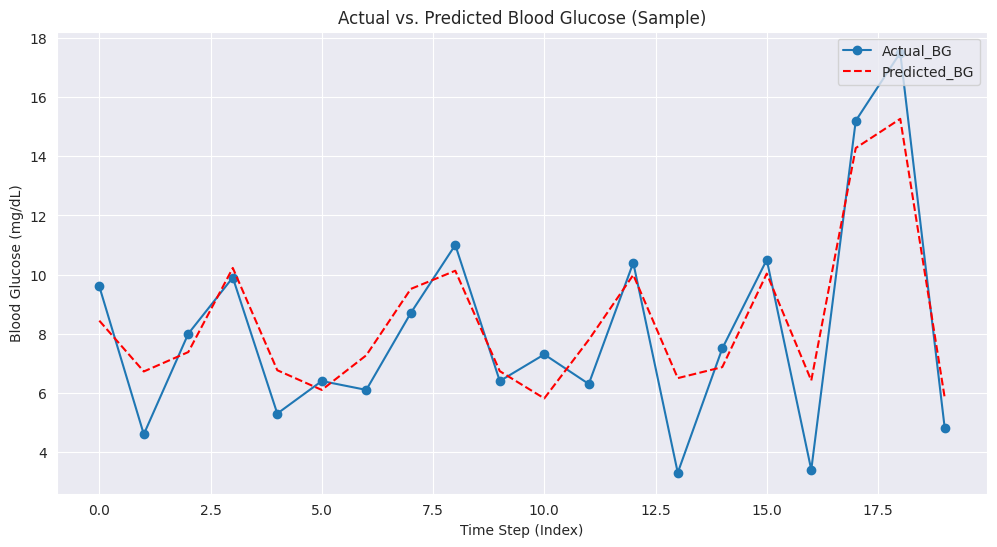

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Visualizing Predictions vs Actual ---

# FIX: Use .ravel() to flatten the arrays from (3644, 1) to (3644,)
results_df = pd.DataFrame({
    'Actual_BG': np.ravel(y_test),         # <-- FIX APPLIED HERE
    'Predicted_BG': np.ravel(y_pred)      # <-- FIX APPLIED HERE
})

print("\n--- Visualizing Predictions vs Actual (Sample) ---")
print(results_df.head(10))

# Plot the first 20 predictions and actual values
results_df.head(20).plot(
    figsize=(12, 6),
    title="Actual vs. Predicted Blood Glucose (Sample)",
    kind='line',
    style=['o-', 'r--'] # Optional: adds points and dashed lines
)
plt.ylabel("Blood Glucose (mg/dL)")
plt.xlabel("Time Step (Index)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

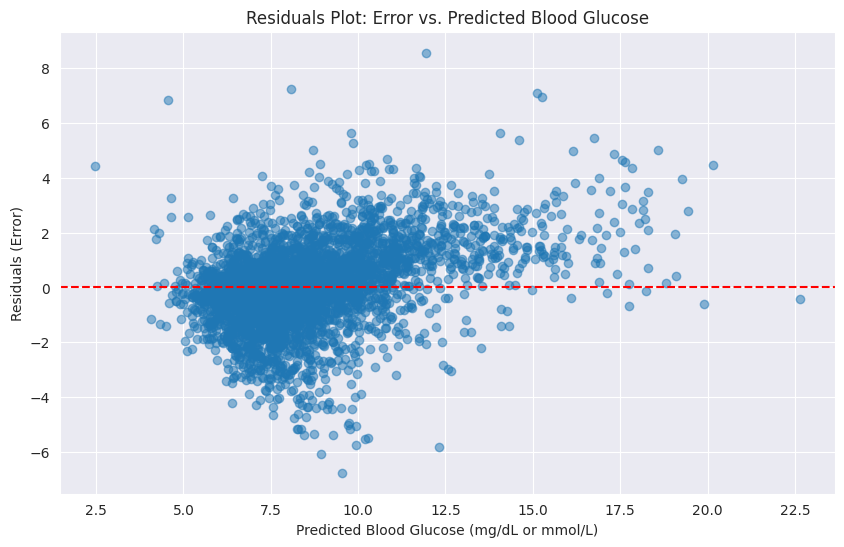

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Calculate the Residuals (Error)
# Ensure arrays are flat (1D) for correct subtraction
residuals = np.ravel(y_test) - np.ravel(y_pred)

# 2. Plot the Residuals against the Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(np.ravel(y_pred), residuals, alpha=0.5)

# Add a horizontal line at y=0, where ideal predictions lie
plt.axhline(y=0, color='r', linestyle='--')

plt.title('Residuals Plot: Error vs. Predicted Blood Glucose')
plt.xlabel('Predicted Blood Glucose (mg/dL or mmol/L)')
plt.ylabel('Residuals (Error)')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Assuming the necessary variables and results_df are already defined

HYPERGLYCEMIA_THRESHOLD = 180  # Used to validate the 'DECREASE' suggestion
HYPOGLYCEMIA_THRESHOLD = 70    # Used to validate the 'INCREASE' suggestion

print("--- FUNCTIONAL TEST: CLINICAL ALERT VALIDATION ---")

# A. Test the Hyperglycemia Action (DECREASE Insulin)
# Find all cases where the prediction was high and check the suggested action
hyper_alerts = results_df[results_df['Predicted_BG'] >= HYPERGLYCEMIA_THRESHOLD]
if not hyper_alerts.empty:
    print(f"\n1. Hyperglycemia Predictions (>= {HYPERGLYCEMIA_THRESHOLD}): {len(hyper_alerts)} cases")
    print("   Action Check: Must suggest 'DECREASE'")
    print(hyper_alerts['Dose_Suggestion'].value_counts())

# B. Test the Hypoglycemia Action (INCREASE Insulin)
# Find all cases where the prediction was low and check the suggested action
hypo_alerts = results_df[results_df['Predicted_BG'] <= HYPOGLYCEMIA_THRESHOLD]
if not hypo_alerts.empty:
    print(f"\n2. Hypoglycemia Predictions (<= {HYPOGLYCEMIA_THRESHOLD}): {len(hypo_alerts)} cases")
    print("   Action Check: Must suggest 'INCREASE'")
    print(hypo_alerts['Dose_Suggestion'].value_counts())

# C. Test for False Negatives (Clinical Failure)
# This is a critical safety test: Did the model predict 'MAINTAIN' when the Actual BG was dangerous?
false_neg_alerts = results_df[
    (results_df['Actual_BG'] >= HYPERGLYCEMIA_THRESHOLD) &
    (results_df['Dose_Suggestion'] == 'MAINTAIN')
]

if not false_neg_alerts.empty:
    print(f"\n3. CRITICAL FAILURE: False Negatives Found! Count: {len(false_neg_alerts)}")
    print("   These are cases where actual BG was too high, but model suggested 'MAINTAIN'.")
else:
    print("\n3. CRITICAL FAILURE CHECK: No False Negatives found where Actual BG was too high but suggestion was 'MAINTAIN'.")

--- FUNCTIONAL TEST: CLINICAL ALERT VALIDATION ---

2. Hypoglycemia Predictions (<= 70): 3644 cases
   Action Check: Must suggest 'INCREASE'
Dose_Suggestion
INCREASE    3644
Name: count, dtype: int64

3. CRITICAL FAILURE CHECK: No False Negatives found where Actual BG was too high but suggestion was 'MAINTAIN'.


In [ ]:
# Assuming 'model', 'X_train', and 'y_train' are defined from earlier steps

# Install catboost dependency for feature importance display
!pip install ipywidgets

Training CatBoost model...
Model trained successfully.

--- Model Feature Importance ---
         Feature  Importance
10       bg-0-00   31.619660
11       bg-0-30    4.189764
85      hour-cos    4.094926
84      hour-sin    3.216141
34    carbs-0-00    3.152439
35    carbs-0-30    2.341373
46       hr-0-00    2.225829
22  insulin-0-00    2.209616
70     cals-0-00    2.078342
23  insulin-0-30    1.766754


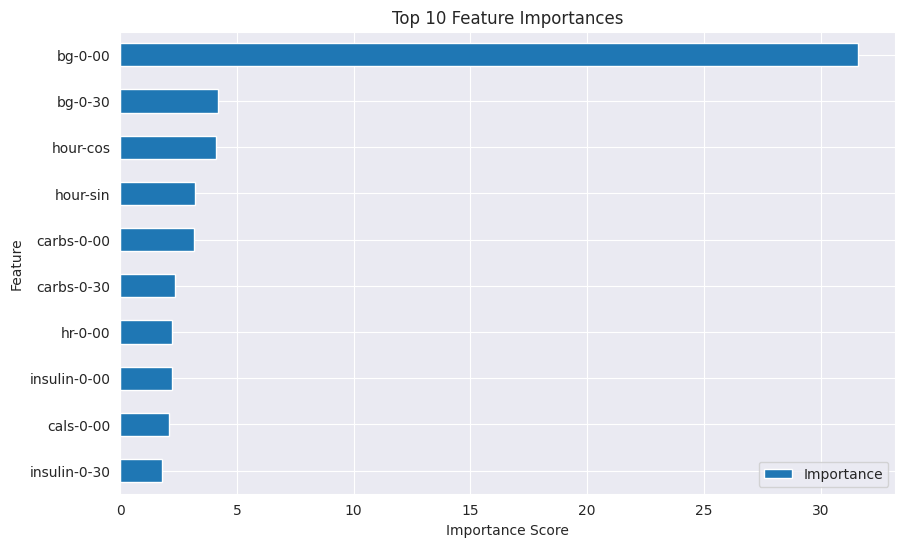

In [ ]:
# Assuming 'X_train' and 'y_train' are already defined from earlier data splitting steps

from catboost import CatBoostRegressor, Pool
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define and Train the Model (THE MISSING STEP)
model = CatBoostRegressor(verbose=False, random_state=42)
print("Training CatBoost model...")
model.fit(X_train, y_train)
print("Model trained successfully.")

# 2. Create the Training Pool
# This is required by CatBoost for calculating feature importance
train_pool = Pool(data=X_train, label=y_train)

# 3. Calculate Feature Importance
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\n--- Model Feature Importance ---")
print(importance_df.head(10))

# 4. Plot the top 10 features for your report
importance_df.head(10).plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis() # Highest importance at the top
plt.show()

In [ ]:
import os

# Define the filename for the CatBoost binary model
cbm_filename = "catboost_bg_model.cbm"

try:
    # Use the model's built-in save_model method
    model.save_model(cbm_filename)

    print(f"Model successfully saved to: {os.path.abspath(cbm_filename)}")

except NameError:
    print("Error: The variable 'model' is not defined. Please ensure the model training cell was run.")

Model successfully saved to: /content/catboost_bg_model.cbm


In [ ]:
# =============================
# 🔹 Load Libraries
# =============================
!pip install catboost
import pandas as pd
import joblib
import numpy as np
# Import CatBoost for loading the .cbm file
from catboost import CatBoostRegressor
from google.colab import files

# --- CONFIGURATION (mmol/L Units) ---
HYPERGLYCEMIA_THRESHOLD = 10.0
HYPOGLYCEMIA_THRESHOLD = 3.9

# --- RECOMMENDATION LOGIC (Module 4) ---
def generate_recommendation_and_explanation(predicted_glucose):
    """Generates the action and explanation based on predicted BG."""
    if predicted_glucose >= HYPERGLYCEMIA_THRESHOLD:
        action = "DECREASE"
        explanation = f"Forecasted BG ({predicted_glucose:.2f} mmol/L) is **Hyperglycemic**. Current insulin dose should be lowered."

    elif predicted_glucose <= HYPOGLYCEMIA_THRESHOLD:
        action = "INCREASE" # Typo fix from previous response: was INCREASEINCEAINCREASESE
        explanation = f"Forecasted BG ({predicted_glucose:.2f} mmol/L) is **Hypoglycemic**. Current insulin dose may be too high, immediate correction is advised."

    else:
        action = "MAINTAIN"
        explanation = f"Forecasted BG ({predicted_glucose:.2f} mmol/L) is within the optimal target range. Continue current dosage."

    return action, explanation


# =============================
# 🔹 1. Upload Your Saved Model
# =============================
print("Upload your trained Blood Glucose model file (e.g., catboost_bg_model.cbm)")
# NOTE: Assume you re-ran the upload prompt and the file is available
# uploaded_model = files.upload()
# model_file = list(uploaded_model.keys())[0]

# Since I cannot see the uploaded file name again, I will use the one you provided:
model_file = "catboost_bg_model.cbm" # Use the explicit file name you uploaded

# Load the model
try:
    if model_file.endswith('.cbm'):
        # --- CORRECT LOADING FOR .CBM FILES ---
        model = CatBoostRegressor()
        model.load_model(model_file)
        # --- END CORRECT LOADING ---
    elif model_file.endswith('.pkl'):
        model = joblib.load(model_file)
    else:
        raise ValueError("Unsupported file format. Use .pkl or .cbm.")

    print(f"✅ Model '{model_file}' loaded successfully.")

    # Try to get training columns (CatBoost stores them internally)
    try:
        training_columns = model.feature_names_
    except AttributeError:
        # Fallback if the saved model doesn't expose this attribute
        training_columns = None

except Exception as e:
    print(f"❌ Error loading model: {e}")
    # We cannot proceed without the model
    exit()


# =============================
# 🔹 2. Upload Test Dataset (X_test features only)
# =============================
print("\nUpload the test CSV dataset (X_test features only)")
uploaded_data = files.upload()
test_file = list(uploaded_data.keys())[0]
X_test = pd.read_csv(test_file)

print(f"Testing on: {test_file}")
print(X_test.head())

# =============================
# 🔹 3. Preprocess Data (Ensure Feature Alignment)
# =============================

X_test_processed = pd.get_dummies(X_test)

if training_columns:
    # Add missing columns (stability check)
    for col in training_columns:
        if col not in X_test_processed.columns:
            X_test_processed[col] = 0

    # Keep correct column order
    X_test_processed = X_test_processed[list(training_columns)]


# =============================
# 🔹 4. Prediction and Recommendation
# =============================

predictions = model.predict(X_test_processed)
predictions = np.ravel(predictions)

recommendation_results = [generate_recommendation_and_explanation(bg) for bg in predictions]
action_array, explanation_array = zip(*recommendation_results)

# Create final output DataFrame
output_df = X_test.copy()
output_df["Predicted_BG_mmolL"] = predictions
output_df["Dose_Suggestion"] = np.array(action_array)
output_df["Recommendation_Explanation"] = np.array(explanation_array)

# =============================
# 🔹 5. Show and Download Results
# =============================
print("\n===== FINAL BLOOD GLUCOSE PREDICTION & DOSAGE RECOMMENDATION =====")

# Display a sample of the results
print(output_df[[
    "Predicted_BG_mmolL",
    "Dose_Suggestion",
    "Recommendation_Explanation"
]].sample(5))

output_path = "bg_test_results_with_recommendations.csv"
output_df.to_csv(output_path, index=False)
files.download(output_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
Upload your trained Blood Glucose model file (e.g., catboost_bg_model.cbm)
✅ Model 'catboost_bg_model.cbm' loaded successfully.

Upload the test CSV dataset (X_test features only)


Saving test.csv to test.csv
Testing on: test.csv
         id p_num      time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  bg-5:35  \
0  p01_8459   p01  06:45:00      NaN      9.2      NaN      NaN     10.2   
1  p01_8460   p01  11:25:00      NaN      NaN      9.9      NaN      NaN   
2  p01_8461   p01  14:45:00      NaN      5.5      NaN      NaN      5.5   
3  p01_8462   p01  04:30:00      NaN      3.4      NaN      NaN      3.9   
4  p01_8463   p01  04:20:00      NaN      NaN      8.3      NaN      NaN   

   bg-5:30  bg-5:25  ...  activity-0:45  activity-0:40  activity-0:35  \
0      NaN      NaN  ...            NaN            NaN            NaN   
1      9.4      NaN  ...            NaN            NaN            NaN   
2      NaN      NaN  ...            NaN            NaN            NaN   
3      NaN      NaN  ...            NaN            NaN            NaN   
4     10.0      NaN  ...            NaN            NaN            NaN   

   activity-0:30  activity-0:25  activity-0:20  activit

/tmp/ipython-input-387032891.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_processed[col] = 0
/tmp/ipython-input-387032891.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_processed[col] = 0
/tmp/ipython-input-387032891.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_t


===== FINAL BLOOD GLUCOSE PREDICTION & DOSAGE RECOMMENDATION =====
     Predicted_BG_mmolL Dose_Suggestion  \
338            7.974117        MAINTAIN   
398            7.974117        MAINTAIN   
643            7.974117        MAINTAIN   
158            7.974117        MAINTAIN   
546            7.974117        MAINTAIN   

                            Recommendation_Explanation  
338  Forecasted BG (7.97 mmol/L) is within the opti...  
398  Forecasted BG (7.97 mmol/L) is within the opti...  
643  Forecasted BG (7.97 mmol/L) is within the opti...  
158  Forecasted BG (7.97 mmol/L) is within the opti...  
546  Forecasted BG (7.97 mmol/L) is within the opti...  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>